This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fconference-ia/master?urlpath=lab/tree/notebooks/4b_linear_models_lasso_logistic/)

# South Africa Heart Diseases Data
A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of Coranary Heart Disease (CHD). Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in Rousseauw et al, 1983, South African Medical Journal. 

| Variable name     | Description              |
|:---------|:-------------------------|
| sbp	  |	systolic blood **pressure** |
| tobacco	|	cumulative **tobacco** (kg) |
| ldl |		low densiity lipoprotein **cholesterol** |
| adiposity |                                     |
| famhist	 |	**family** history of heart disease (Present=1, Absent=0) |
| typea	|	type-A **behavior** |
| obesity |            |
| alcohol	|	current **alcohol** consumption |
| age		| **age** at onset |
| chd		| **response**: coronary heart disease  (Present=1, Absent=0) |

#### Load the data set

In [1]:
import pandas as pd
import numpy as np

#load data set
heart = pd.read_csv('SAheart.csv', sep=',', header=0)
heart.head() #data overview: variable names and first values

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


#### Display some summary statistics

In [2]:
heart.describe()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,231.935065,138.326840,3.635649,4.740325,25.406732,0.415584,53.103896,26.044113,17.044394,42.816017,0.346320
std,133.938585,20.496317,4.593024,2.070909,7.780699,0.493357,9.817534,4.213680,24.481059,14.608956,0.476313
min,1.000000,101.000000,0.000000,0.980000,6.740000,0.000000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,116.250000,124.000000,0.052500,3.282500,19.775000,0.000000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,231.500000,134.000000,2.000000,4.340000,26.115000,0.000000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,347.750000,148.000000,5.500000,5.790000,31.227500,1.000000,60.000000,28.497500,23.892500,55.000000,1.000000
max,463.000000,218.000000,31.200000,15.330000,42.490000,1.000000,78.000000,46.580000,147.190000,64.000000,1.000000


#### Format the input/target data set

In [3]:
y = np.asarray( heart.iloc[:,10], 'float' )
X = np.asarray( heart.iloc[:,1:10], 'float' )
names = list(heart.columns[1:10]) # variable names
y = heart.iloc[:,10]
X = heart.iloc[:,1:10]

# Data matrix X is (n,p) where p is the number of variable and n the number of sample
(n,p) = X.shape
ncases = int(np.sum(y)) # number of cases
print('There is {} samples: {} cases and {:d} control'.format(n,ncases,n-ncases))

There is 462 samples: 160 cases and 302 control


## Compute ordinary (without regularization) Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from time import time

# Standardize the data (useful to compare the variable weights)
sc = StandardScaler()
X = heart.iloc[:,1:10]
Xs= sc.fit_transform(X)

print("Computing LR estimates ...")
start = time()
clf = LogisticRegression(penalty='none', tol=1e-6, max_iter=int(1e6))
clf.fit(Xs, y)
print("This took %0.3fs" % (time() - start))
betas = pd.DataFrame.from_records(clf.coef_, columns=names, index=['Weights'])
betas['intercept'] = clf.intercept_
print('Estimated Weights for standardized variables:\n')
betas.head()

Computing LR estimates ...
This took 0.004s
Estimated Weights for standardized variables:



,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,intercept
Weights,0.133162,0.364183,0.359791,0.144465,0.456047,0.388312,-0.264795,0.002981,0.659973,-0.878543


**Exercise**:
- what does a positive, negative or near-zero weight mean to predict heart disease?
- How do you interpret the weight of obesity for instance?
- How can you explain such surprising findings?

## Compute $\ell_1$ penalized  Logistic Regression and lasso path

Regularization functions such as $\ell_1$ or $\ell_2$ penalty (or combined $\ell_1$/$\ell_2$ penalty as in *elastic net*)  can also be used in generalized linear model such that Logistic Regression. The residual sum of squares criterion used for linear regression is then replaced by the opposite of the (conditional) log likelihood. 
For instance for Logitic Regression with Lasso-type regularization ($\ell_1$ penalty), this yields for binary classification $y_i \in \{-1,+1\}$ the following optimization problem:
$$
\min_{\beta}   \sum_{i=1}^n \log(\exp(- y_i (X_i^T \beta )) + 1) +  \lambda \| \beta \|_1.
$$
Within scikit-learn, penalized Logistic Regression is available through the `penalty` parameter of [`linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.htm),  parameter `C` being the inverse of regularization strength such that $C=\frac{1}{\lambda}$ 

In [5]:
#compute lasso path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.svm import l1_min_c

import matplotlib.pyplot as plt

# Standardize the data! 
# Don't forget that scale matters for penaliezd regression such that Lasso or ridge
# (This is true also for distance based methods s.t. K-NN).
# If one variable has a larger magnitude than the other (imagine that you change the 
# unity for a variable from kilograms to grams), this variable will be much less shrunken than 
# the others.
# Advice: Except if you have a good reason to do the opposite, standardize all your variables 
# to be sure that they are comparable
sc = StandardScaler()
Xs= sc.fit_transform(X) #center  (zero mean) and reduce (unit variance) the variables 

# generate useful values for the regularization parameter (log-scale)
cs = l1_min_c(Xs, y, loss='log') * np.logspace(0, 4, 30)

# Use a stochastic gradient descent 
print("Computing regularization path ...")
start = time()
clf = LogisticRegression(penalty='l1', solver='saga',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True)
coefs_ = []
beta_l1norm = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(Xs, y)
    beta_l1norm.append( np.sum(np.abs(clf.coef_.ravel()))) 
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

betas = np.array(coefs_)

Computing regularization path ...
This took 0.085s


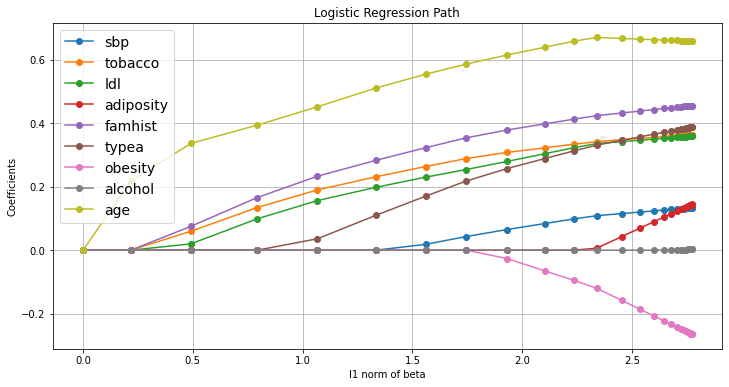

In [6]:
# Display lasso path Vs l1 norm of the coeff vector
plt.figure(figsize=(12,6))
#plt.plot(np.log10(cs), coefs_, marker='o')
plt.plot(beta_l1norm, betas, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('l1 norm of beta')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.legend(names, fontsize=14)
plt.grid('On')
plt.show()

### Cross validation of the LR model with Lasso penalty

We estimate now the optimal regularization parameter

In [7]:
from sklearn.linear_model import LogisticRegressionCV

print("Computing K-fold CV ...")
# K fold cross validation  (K=5)
start = time()
cs = l1_min_c(Xs, y, loss='log') * np.logspace(0, 2, 50) # the vector fot the alpha (lasso penalty parameter) values
model = LogisticRegressionCV(Cs=cs, cv=5, penalty='l1', solver='saga', tol=1e-6).fit(Xs,y)
print("This took %0.3fs" % (time() - start))

Computing K-fold CV ...
This took 0.419s


In [9]:
# Now model is tuned with the penalty parameter estimated by CV
lambda_cv = model.C_[0]
# The coef estimated with CV
beta_l1norm = np.sum(np.abs(model.coef_))

print('CV estimates:')
print('- lambda = {:.3f}, which yields ||beta||_1 = {:.3f}\n'.format(lambda_cv,beta_l1norm) )
print('CV weights for standardized variables:')
betas_cv = pd.DataFrame.from_records(model.coef_, columns=names, index=['Weights'])
betas_cv['intercept'] = clf.intercept_
betas_cv.head()

CV estimates:
- lambda = 0.060, which yields ||beta||_1 = 1.342

CV weights for standardized variables:


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,intercept
Weights,0.0,0.232515,0.199362,0.0,0.284652,0.11216,0.0,0.0,0.513103,-0.878436


### Exercise
- What are the only significant variables estimated with cross-validation? 
- How can we rank them by significance order (*hint: look at the lasso path*)?
- Do these results seem more credible (than those obtain without regularization) to predict heart diseases? 

### Compute the predicted CHD probability for some patients

For this kind of problem, we are more of course more interested in the modeling between the inputs/response variables and their interpretation rather than the only prediction of the binary responses  (CHD or not). With a generalized linear model such that LR, it is possible to compute a risk probability for each patient and to assess and to interpret the influence of each variable.  

In [10]:
# Get the predicted risk for the first patient
ipatient = 0 # patient index
x = Xs[ipatient,:].reshape(1, -1)
x = pd.DataFrame.from_records(x, columns=names)
ylabel = 'Case' if y[ipatient] else 'Control'
print("{} Patient with (standardized) features:\n{}\n".format(ylabel, x))

# TODO: increase/decrease tobacco consumption
x_copy = x.copy()
x_copy['tobacco'] += 0 # offset to add in standardized unit

# Proba of heart disease
proba_CHD_0 = model.predict_proba(x)[0,1]
proba_CHD = model.predict_proba(x_copy)[0,1]
print("Proba of coronary heart disease (CHD): {:.3f}".format(proba_CHD))
print("Odds probability of CHD: {:.3f}".format(proba_CHD/(1-proba_CHD)))

Case Patient with (standardized) features:
        sbp   tobacco       ldl  adiposity   famhist    typea   obesity  \
0  1.058564  1.823073  0.478412  -0.295503  1.185854 -0.41847 -0.176786   

    alcohol       age  
0  3.277738  0.629336  

Proba of coronary heart disease (CHD): 0.596
Odds probability of CHD: 1.473


### Exercice (*Optional*)
-  Based on the logistic regression formula to compute the probability of each class  (with, or without CHD) and the values of the estimated weights, what would be the increase factor on the odds probability $$\frac{ \Pr(\textrm{"CHD"} |X=x)}{\Pr( \textrm{"no CHD"}|X=x)}$$ when the tobacco consumption increases of 1 (in standardized unit)? 
- Check this by adding an offset  to the tobbaco variable in the cell above and comparing the obtained odds

## Greedy variable selection procedure

An alternative to Lasso penalization to select the most significant variables and regularize the problem is to fit all the possible combination of variables and choose the best one (for instance that minimizes the test error). This is called *best subset criterion*.  However this approach is very computationnaly demanding. With $p$ variables, we need to fit $2^p$ models. Additionally, if we want to use cross-validation to evaluate and compare their performances, the problem quickly becomes unfeasible...

Greedy algorithm are then useful procedures that select the best variables (forward selection) or remove the worst variables (backward selection) **step by step**. There is generally no longer any guarantee of converging towards the best subset solution, but this may give useful solutions at a much reduced computational cost.

### Exercise:
- for our heart diseases dataset, usig a $K=5$-fold CV, how many fits would be required to find the best subset?

### Backward selection: Recursive Feature Elimination (RFE)

Given a prediction rule that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select variables (the features) by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set.

Within scikit-learn, recursive feature elimination is available with [`feature_selection.RFE`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html): for a linear model such that Logistic Regression, the importance of the features is obtained through their coefficients (pay attention to scale your data!). The recursive feature elimination is repeated until the desired number of features to select is reached.

In [10]:
from sklearn.feature_selection import RFE, RFECV
clf = LogisticRegression(penalty='none', tol=1e-6, max_iter=int(1e6))
start = time()
selector = RFE(clf, n_features_to_select=4, step=1)
selector = selector.fit(Xs, y)
print("This took %0.3fs" % (time() - start))
print("The selected variables are: {}".format(np.array(names)[selector.support_]))
sel_ind_sorted = np.argsort(selector.ranking_)
ranking = pd.DataFrame.from_records(selector.ranking_[sel_ind_sorted].reshape(1,p), 
                                    columns=[names[i] for i in sel_ind_sorted], index=['Rank'])
ranking.head()

This took 0.017s
The selected variables are: ['tobacco' 'famhist' 'typea' 'age']


,tobacco,famhist,typea,age,ldl,obesity,adiposity,sbp,alcohol
Rank,1,1,1,1,2,3,4,5,6


### Exercise:
- Change the desired number of features to 1 to rank the features by signicance order (most significant variables must enter first in the model). Is it perfectly consistent with the Lasso path ranking?
- What is hyperparameter to optimize for the RFE procedure?  How can you estimate it?
- Replace the RFE procedure by [`feature_selection.RFECV`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) to select the most significant variables. Is it in agreement with the Lasso results?
- Do you think that this procedure is still appropriate when the number of variables $p$ is greater than the sample size $n$ of the training set?

### Forward selection: Orthogonal Matching Pursuit (OMP)

Orthogonal Matching Pursuit (OMP) is based on a greedy algorithm that selects at each step the most significant variable to enter the model. For a linear regression model, this is the variable
most highly correlated with the current residual. It is similar to the simpler matching pursuit (MP) method, but better in that at each iteration, the residual is recomputed using an orthogonal projection on the space of the previously chosen variables.
OMP was introduced in 
> G. Mallat, Z. Zhang, [Matching pursuits with time-frequency dictionaries](http://blanche.polytechnique.fr/~mallat/papiers/MallatPursuit93.pdf), IEEE Transactions on Signal Processing, Vol. 41, No. 12. (December 1993), pp. 3397-3415.

Note also that there exists an other popular method in the statistical literature called *Forward stepwise selection*. The selection step used differs from the one used in OMP in that it selects the variable that will lead to the minimum residual error *after* orthogonalisation. See for instance the following paper for a comparison between both methods
> Blumensath, Thomas, and Mike E. Davies. ["On the difference between orthogonal matching pursuit and orthogonal least squares."](https://eprints.soton.ac.uk/142469/1/BDOMPvsOLS07.pdf) (2007).

This principle can be extented to generalized linear model such that Logistic Regression by replacing the residual sum of squares criterion by the opposite of the log likelihood. 

Within scikit-learn, only OMP is available for linear regression model with [`linear_model.OrthogonalMatchingPursuit`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html). However this can be directly apply to our binary classification problem

In [11]:
# We use Forward selection, aka Orthogonal Matching Pursuit
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV

# Get the 5 most significant features
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=5,fit_intercept=True, normalize=True)
omp.fit(X, y)
coef = omp.coef_
idx_r, = coef.nonzero()

sel_feat_name= [names[l] for l in idx_r] ;
print("Most significant features: {}".format(np.array(names)[omp.coef_.nonzero()]))

Most significant features: ['tobacco' 'ldl' 'famhist' 'typea' 'age']


### Exercise:
- Change the desired number of variables (number of nonzero coefs) from p to 1 to rank the features by signicance order (most significant variables must enter first in the model). Is it perfectly consistent with the previous results?
- What is hyperparameter to optimize for the OMP procedure?  How can you estimate it?
- Replace the OMP procedure by [`linear_model.OrthogonalMatchingPursuitCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html#sklearn.linear_model.OrthogonalMatchingPursuit) to select the most significant variables. Is it in agreement with the previous results?
- *Optional:* Compared to greedy methods that are suboptimal procedures to approximate the best sparse solution (the best subset), Lasso penalty is often presented as a *convex relexation of the sparsity constraint*. Can you explain why? What are the possible benefits/disadvantages of the greedy and lasso procedures?
